# Redes de Computadores 2

## Trabalho Grau B

## Eduardo Müller Berlitz

## Resumo

### 1.   Geração e Codificação

  *   Recebe uma String
  *   Converte para ASCII e depois para binário
  *   Implementa a codificação Manchester

### 2.   Modulação e Demodulação

  *   Implementa Modulação e Demodulação BPSK
  *   Implementa Modulação e Demodulação QPSK

### 3.   Canal AWGN

  *   Implementa AWGN (Ruído Branco)

### 4.   Decodificação Manchester e Reconversão

  *   Implementa a decodificação Manchester
  *   Converte de volta para String

### 5.   Métricas

  *   Calcula a Taxa de Erro de Bits (BER)

### 6.   Simulação Principal

  *   Recebe os parâmetros utilizados (mensagem, valores de SNR e valor gerador de ruído)
  *   Chama as funções dos itens 1 a 5
  *   Armazena BERs em vetores

### 7.   Plot dos Resultados

  *   Gera o gráfico BER x SNR
  *   Compara as modulações (BPSK e QPSK)

## Testes

### 8.   Execução Direta

  *   Define a mensagem que será testada
  *   Define os valores de SNR
  *   Executa a simulação
  *   Executa a geração do gráfico

## Código

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1) Geração e codificação
# ------------------------------

# Converte a mensagem para binário, armazena em um vetor e o retorna
def generate_message(text):
    bits = ''.join(format(ord(c), '08b') for c in text)
    return np.array([int(b) for b in bits], dtype=int)

# Implementa codificação Manchester
# Cria um vetor com o dobro do tamanho do original
# Nos índices pares copia o bit
# Nos índices ímpares coloca o valor inverso
def encode_manchester(bits):
    # Exemplo: bit 1 -> [1,0], bit 0 -> [0,1]
    encoded = np.zeros(len(bits)*2, dtype=int)
    encoded[0::2] = bits
    encoded[1::2] = 1 - bits
    return encoded

# ------------------------------
# 2) Modulação e Demodulação
# ------------------------------

# Implementa Modulação BPSK
# Bit 0 -> -1
# Bit 1 -> +1
def modulate_bpsk(bits):
    return 2*bits - 1

# Implementa Demodulação BPSK
# Usa a parte real do sinal recebido
# Valor positivo -> 1
# Valor negativo -> 0
def demodulate_bpsk(signal):
    return (np.real(signal) > 0).astype(int)

# Implementa Modulação QPSK
# Agrupa os bits em pares
# Usa mapeamento Gray para minimizar erros
def modulate_qpsk(bits):
    n = len(bits)//2*2
    bits = bits[:n]
    s = 1/np.sqrt(2)
    mapping = {
        (0,0): s*(1+1j),
        (0,1): s*(-1+1j),
        (1,1): s*(-1-1j),
        (1,0): s*(1-1j)
    }
    symbols = np.array([mapping[(bits[i], bits[i+1])] for i in range(0, n, 2)])
    return symbols

# Implementa Demodulação QPSK
# Para cada símbolo recebido:
  # Calcula a distância para todos os pontos da constelação
  # Escolhe o mais próximo
  # Devolve os bits correspondentes
def demodulate_qpsk(symbols):
    s = 1/np.sqrt(2)
    mapping = {
        (0,0): s*(1+1j),
        (0,1): s*(-1+1j),
        (1,1): s*(-1-1j),
        (1,0): s*(1-1j)
    }
    points = np.array(list(mapping.values()))
    bit_pairs = list(mapping.keys())
    bits_out = []
    for sym in symbols:
        d = np.abs(sym - points)
        idx = np.argmin(d)
        b0, b1 = bit_pairs[idx]
        bits_out.extend([b0, b1])
    return np.array(bits_out, dtype=int)

# ------------------------------
# 3) Canal AWGN (Ruído Branco)
# ------------------------------

# Converte SNR(dB) para SNR linear
# Mede a potência média do sinal
# Calcula a potência de ruído correspondente
# Gera o ruído gaussiano
# Soma o ruído ao sinal
def awgn(signal, snr_dB):
    snr_linear = 10**(snr_dB/10)
    power_signal = np.mean(np.abs(signal)**2)
    noise_power = power_signal / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))
    if np.isrealobj(signal):
        return signal + np.real(noise)
    else:
        return signal + noise

# ------------------------------
# 4) Decodificação Manchester e Reconversão
# ------------------------------

# Implementa decodificação Manchester
# Divide o vetor em pares
# [0, 1] -> 0 e [1, 0] -> 1
# Detecta erros causados por ruído
# Retorna um vetor contendo os bits originais (ou -1 quando houver erro) e a quantidade de pares inválidos
def decode_manchester(encoded):
    n_pairs = len(encoded)//2
    decoded = np.zeros(n_pairs, dtype=int)
    invalid = 0
    for i in range(n_pairs):
        a = encoded[2*i]
        b = encoded[2*i + 1]
        if a == 0 and b == 1:
            decoded[i] = 0
        elif a == 1 and b == 0:
            decoded[i] = 1
        else:
            decoded[i] = -1
            invalid += 1
    return decoded, invalid

# Converte o vetor de bits para ASCII e depois para a palavra original
# Ignora os bits inválidos
# Se a quantidade de bits válidos não for múltipla de 8, descarta os bits restantes
def bits_to_text(bits):
    valid_bits = bits[bits != -1]
    if len(valid_bits) < 8:
        return ""
    n = len(valid_bits) - (len(valid_bits) % 8)
    valid_bits = valid_bits[:n]
    chars = []
    for i in range(0, len(valid_bits), 8):
        byte = valid_bits[i:i+8]
        val = int("".join(str(int(b)) for b in byte), 2)
        chars.append(chr(val))
    return "".join(chars)

# ------------------------------
# 5) Métricas
# ------------------------------

# Compara bit a bit
# Conta os erros
# Divide pelo número total de bits
def calculate_ber(bits_tx, bits_rx):
    n = min(len(bits_tx), len(bits_rx))
    if n == 0:
        return 0.0
    errors = np.sum(bits_tx[:n] != bits_rx[:n])
    return errors / n

# ------------------------------
# 6) Simulação principal
# ------------------------------

# Gera o valor do ruído
# Converte a mensagem em bits
# Codifica Manchester
# Para cada valor de SNR utilizando BPSK e QPSK:
  # Modula
  # Adiciona o Ruído Branco
  # Demodula
  # Calcula o BER
# Armazena os valores de BER em vetores
# Decodifica Manchester nos sinais demodulados do último SNR
# Converte os bits recuperados para texto
# Imprime:
  # Quantidade de pares Manchester inválidos
  # Mensagem decodificada por BPSK e QPSK
# Retorna os vetores de BER
# Para informações sobre cada valor BER x SNR, alterar 'verbose' para 'True'
def simulate_system(message, snr_values, seed=None, verbose=False):
    if seed is not None:
        np.random.seed(seed)

    bits = generate_message(message)
    encoded = encode_manchester(bits)

    ber_bpsk = []
    ber_qpsk = []

    noisy_bpsk = None
    noisy_qpsk = None
    mod_bpsk = None
    mod_qpsk = None

    for snr in snr_values:
        # BPSK
        mod_bpsk = modulate_bpsk(encoded)
        noisy_bpsk = awgn(mod_bpsk, snr)
        demod_bpsk = demodulate_bpsk(noisy_bpsk)
        ber_bpsk.append(calculate_ber(encoded, demod_bpsk))

        # QPSK
        mod_qpsk = modulate_qpsk(encoded)
        noisy_qpsk = awgn(mod_qpsk, snr)
        demod_qpsk = demodulate_qpsk(noisy_qpsk)
        ber_qpsk.append(calculate_ber(encoded[:len(demod_qpsk)], demod_qpsk))

        if verbose:
            print(f"SNR={snr:2d} dB: BER_BPSK={ber_bpsk[-1]:.6f}, BER_QPSK={ber_qpsk[-1]:.6f}")

    # ------------------------------
    # Decodificação Manchester e Impressão da Mensagem
    # ------------------------------
    if noisy_bpsk is not None and noisy_qpsk is not None:
        demod_bpsk_full = demodulate_bpsk(noisy_bpsk)
        decoded_bpsk, invalid_bpsk = decode_manchester(demod_bpsk_full)
        msg_bpsk = bits_to_text(decoded_bpsk)

        demod_qpsk_full = demodulate_qpsk(noisy_qpsk)
        decoded_qpsk, invalid_qpsk = decode_manchester(demod_qpsk_full)
        msg_qpsk = bits_to_text(decoded_qpsk)

        print("\n----- Decodificação da Mensagem -----")
        print(f"Quantidade de pares Manchester inválidos encontrados: BPSK={invalid_bpsk}, QPSK={invalid_qpsk}")
        print("Mensagem decodificada (BPSK):", msg_bpsk)
        print("Mensagem decodificada (QPSK):", msg_qpsk)
    else:
        print("Nenhum sinal ruidoso disponível para decodificação.")

    return ber_bpsk, ber_qpsk

# ------------------------------
# 7) Plot dos Resultados
# ------------------------------

# Gera o gráfico BER x SNR
# Compara BPSK e QPSK
# Printa o gráfico na tela
def plot_results(snr_values, ber_bpsk, ber_qpsk, outpath="ber_comparison.png"):
    plt.figure(figsize=(8,6))
    plt.semilogy(snr_values, ber_bpsk, 'o-', label='BPSK')
    plt.semilogy(snr_values, ber_qpsk, 's-', label='QPSK')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.title("Comparação de Desempenho - BPSK vs QPSK")
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()


## Testes

### Teste 1

Parâmetros utilizados:

* Mensagem: Eduardo Muller Berlitz
* Valores SNR (SNR Inicial, SNR final + 1, Intervalo entre valores): (0, 21, 2)
* Valor gerador de ruído: 42


----- Decodificação da Mensagem -----
Quantidade de pares Manchester inválidos encontrados: BPSK=0, QPSK=0
Mensagem decodificada (BPSK): Eduardo Muller Berlitz
Mensagem decodificada (QPSK): Eduardo Muller Berlitz


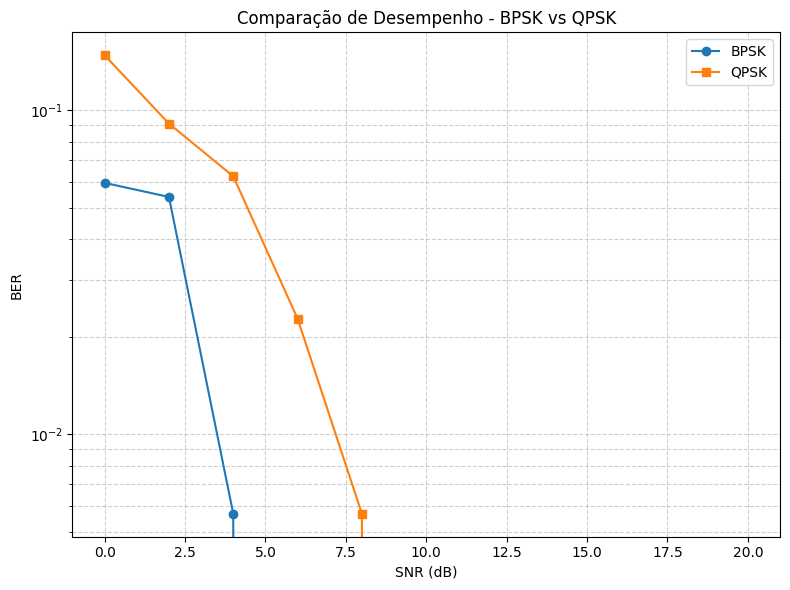

In [ ]:
# ------------------------------
# 8) Execução direta
# ------------------------------

# Define a mensagem de teste
# Define os valores de SNR (SNR Inicial, SNR final + 1, Intervalo entre valores analisados)
# Executa a simulação
# Gera o gráfico
if __name__ == "__main__":
    message = "Eduardo Muller Berlitz"
    snr_db_values = np.arange(0, 21, 2)
    ber_bpsk, ber_qpsk = simulate_system(message, snr_db_values, seed=42)
    plot_results(snr_db_values, ber_bpsk, ber_qpsk)

### Teste 2

Parâmetros utilizados:

* Mensagem: abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
* Valores SNR (SNR Inicial, SNR final + 1, Intervalo entre valores): (0, 21, 2)
* Valor gerador de ruído: 42


----- Decodificação da Mensagem -----
Quantidade de pares Manchester inválidos encontrados: BPSK=0, QPSK=0
Mensagem decodificada (BPSK): abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
Mensagem decodificada (QPSK): abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


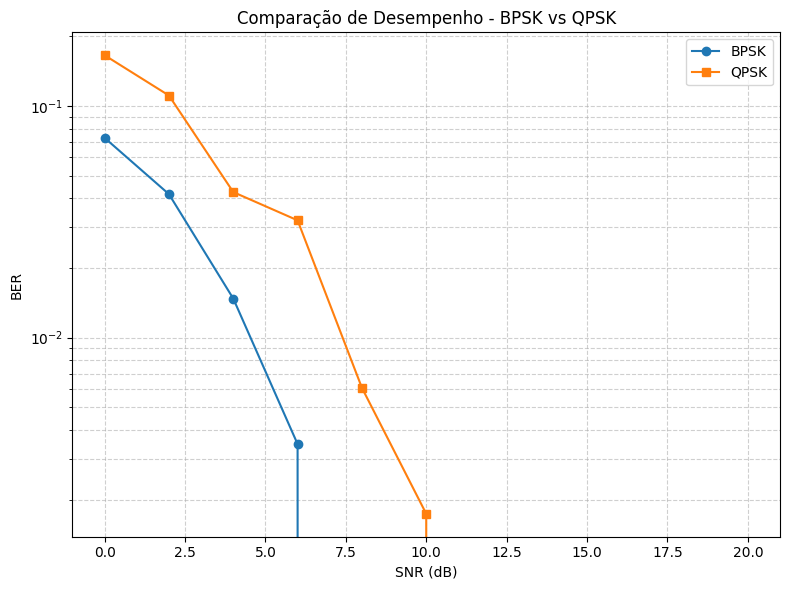

In [ ]:
if __name__ == "__main__":
    message = "abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    snr_db_values = np.arange(0, 21, 2)
    ber_bpsk, ber_qpsk = simulate_system(message, snr_db_values, seed=42)
    plot_results(snr_db_values, ber_bpsk, ber_qpsk)

### Teste 3

Parâmetros utilizados:

* Mensagem: O trabalho deve ser realizado individualmente e consistirá na implementação de um sistema completo de transmissão digital.
* Valores SNR (SNR Inicial, SNR final + 1, Intervalo entre valores): (0, 21, 2)
* Valor gerador de ruído: 42


----- Decodificação da Mensagem -----
Quantidade de pares Manchester inválidos encontrados: BPSK=0, QPSK=0
Mensagem decodificada (BPSK): O trabalho deve ser realizado individualmente e consistirá na implementação de um sistema completo de transmissão digital.
Mensagem decodificada (QPSK): O trabalho deve ser realizado individualmente e consistirá na implementação de um sistema completo de transmissão digital.


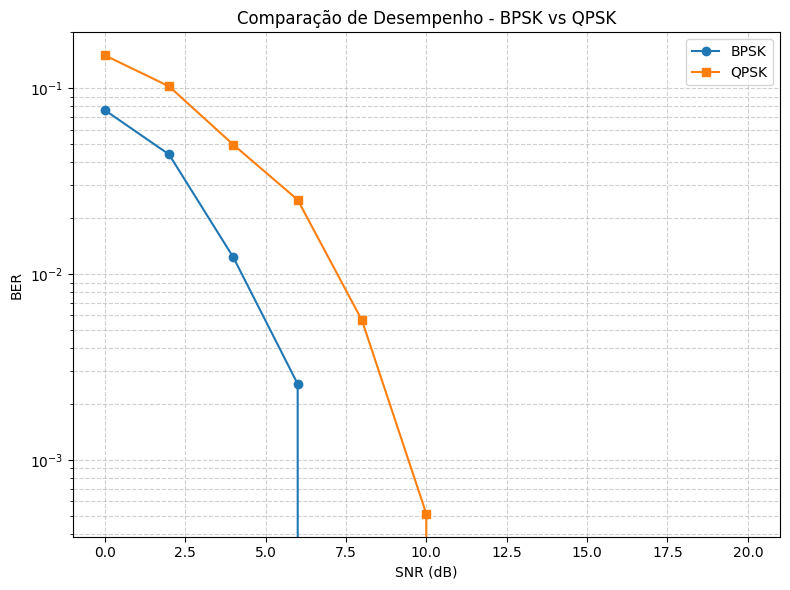

In [ ]:
if __name__ == "__main__":
    message = "O trabalho deve ser realizado individualmente e consistirá na implementação de um sistema completo de transmissão digital."
    snr_db_values = np.arange(0, 21, 2)
    ber_bpsk, ber_qpsk = simulate_system(message, snr_db_values, seed=42)
    plot_results(snr_db_values, ber_bpsk, ber_qpsk)

### Teste 4

Parâmetros utilizados:

* Mensagem: Desenvolver e aplicar os conceitos de codificação de canal e modulação digital estudados na disciplina de Redes de Computadores analisando seu impacto na taxa de erro de bits (BER) e na eficiência espectral de sistemas de comunicação.
* Valores SNR (SNR Inicial, SNR final + 1, Intervalo entre valores): (0, 21, 2)
* Valor gerador de ruído: 42


----- Decodificação da Mensagem -----
Quantidade de pares Manchester inválidos encontrados: BPSK=0, QPSK=0
Mensagem decodificada (BPSK): Desenvolver e aplicar os conceitos de codificação de canal e modulação digital estudados na disciplina de Redes de Computadores analisando seu impacto na taxa de erro de bits (BER) e na eficiência espectral de sistemas de comunicação.
Mensagem decodificada (QPSK): Desenvolver e aplicar os conceitos de codificação de canal e modulação digital estudados na disciplina de Redes de Computadores analisando seu impacto na taxa de erro de bits (BER) e na eficiência espectral de sistemas de comunicação.


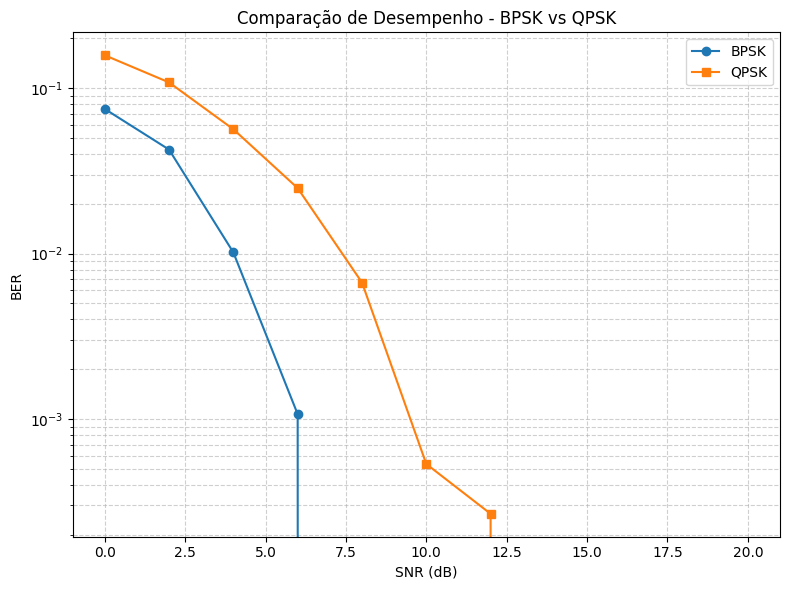

In [ ]:
if __name__ == "__main__":
    message = "Desenvolver e aplicar os conceitos de codificação de canal e modulação digital estudados na disciplina de Redes de Computadores analisando seu impacto na taxa de erro de bits (BER) e na eficiência espectral de sistemas de comunicação."
    snr_db_values = np.arange(0, 21, 2)
    ber_bpsk, ber_qpsk = simulate_system(message, snr_db_values, seed=42)
    plot_results(snr_db_values, ber_bpsk, ber_qpsk)